# Frame2 → bolus attention model (no clean reconstruction)
Predict bolus mask directly from frame2 using the attention fusion head (single input channel).

In [1]:
from pathlib import Path
from collections import defaultdict
import random
import re
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import cv2
import matplotlib.pyplot as plt
import torch.nn.functional as F

DATA_ROOT = Path('.')
IMAGES_DIR = DATA_ROOT / 'images'
MASKS_DIR = DATA_ROOT / 'masks'
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4
NUM_WORKERS = 0
ATTN_EPOCHS = 20
ATTN_LR = 1e-3
DICE_WEIGHT = 0.5

device = torch.device('mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu'))
PIN_MEMORY = device.type == 'cuda'
print('Using device', device)


Using device mps


In [2]:
FILENAME_PATTERN = re.compile(r"^(?P<prefix>[A-Za-z0-9]{6})(?P<frame>\d+)_")

def parse_frame_key(path: Path):
    m = FILENAME_PATTERN.match(path.stem)
    if not m:
        raise ValueError(f"Bad filename: {path.name}")
    return m.group('prefix'), int(m.group('frame'))

def load_gray(path: Path) -> np.ndarray:
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(path)
    return img

def collect_pairs(images_dir: Path, masks_dir: Path) -> pd.DataFrame:
    grouped = defaultdict(list)
    for img_path in images_dir.glob('*.png'):
        try:
            prefix, frame_idx = parse_frame_key(img_path)
        except ValueError:
            continue
        grouped[prefix].append((frame_idx, img_path))

    rows = []
    for prefix, frames in grouped.items():
        frames.sort(key=lambda x: x[0])
        for (idx_prev, path_prev), (_, path_next) in zip(frames, frames[1:]):
            mask_prev = masks_dir / path_prev.name
            if not mask_prev.exists():
                continue
            rows.append({
                'frame1': path_prev,  # only mask1 used, input is frame2
                'frame2': path_next,
                'mask1': mask_prev,
                'sequence': prefix,
                'frame_idx': idx_prev,
            })
    return pd.DataFrame(rows)

pairs_df = collect_pairs(IMAGES_DIR, MASKS_DIR)
print('Total pairs:', len(pairs_df), '| sequences:', pairs_df['sequence'].nunique())
if len(pairs_df) == 0:
    raise RuntimeError('No pairs found; check IMAGES_DIR and MASKS_DIR')
pairs_df.head()


Total pairs: 6337 | sequences: 87


,frame1,frame2,mask1,sequence,frame_idx
0,images/ns055b554_resized_512.png,images/ns055b556_resized_512.png,masks/ns055b554_resized_512.png,ns055b,554
1,images/ns055b556_resized_512.png,images/ns055b558_resized_512.png,masks/ns055b556_resized_512.png,ns055b,556
2,images/ns055b558_resized_512.png,images/ns055b560_resized_512.png,masks/ns055b558_resized_512.png,ns055b,558
3,images/ns055b560_resized_512.png,images/ns055b562_resized_512.png,masks/ns055b560_resized_512.png,ns055b,560
4,images/ns055b562_resized_512.png,images/ns055b564_resized_512.png,masks/ns055b562_resized_512.png,ns055b,562


In [3]:
seqs = pairs_df['sequence'].unique()
train_seq, temp_seq = train_test_split(seqs, test_size=0.30, random_state=SEED, shuffle=True)
val_seq, test_seq = train_test_split(temp_seq, test_size=0.50, random_state=SEED, shuffle=True)

splits = {
    'train': pairs_df[pairs_df['sequence'].isin(train_seq)].reset_index(drop=True),
    'val': pairs_df[pairs_df['sequence'].isin(val_seq)].reset_index(drop=True),
    'test': pairs_df[pairs_df['sequence'].isin(test_seq)].reset_index(drop=True),
}
for name, df in splits.items():
    print(f"{name}: {len(df)} samples | sequences: {df['sequence'].nunique()}")


train: 4315 samples | sequences: 60
val: 795 samples | sequences: 13
test: 1227 samples | sequences: 14


In [4]:
class Frame2Dataset(Dataset):
    def __init__(self, df: pd.DataFrame, augment: bool = False):
        self.df = df.reset_index(drop=True)
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        frame2 = load_gray(row['frame2']).astype(np.float32) / 255.0
        mask1 = load_gray(row['mask1'])
        mask1 = (mask1 > 0).astype(np.float32)

        if self.augment:
            if random.random() < 0.5:
                frame2 = np.flip(frame2, axis=1).copy()
                mask1 = np.flip(mask1, axis=1).copy()
            if random.random() < 0.5:
                frame2 = np.flip(frame2, axis=0).copy()
                mask1 = np.flip(mask1, axis=0).copy()

        frame2_t = torch.from_numpy(frame2).unsqueeze(0)
        mask1_t = torch.from_numpy(mask1).unsqueeze(0)
        return frame2_t, mask1_t

data_loaders = {
    'train': DataLoader(Frame2Dataset(splits['train'], augment=True), batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY),
    'val': DataLoader(Frame2Dataset(splits['val']), batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY),
    'test': DataLoader(Frame2Dataset(splits['test']), batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY),
}

x, y = next(iter(data_loaders['train']))
print('Train batch shapes:', x.shape, y.shape)


Train batch shapes: torch.Size([4, 1, 512, 512]) torch.Size([4, 1, 512, 512])


In [5]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

class ChannelAttention(nn.Module):
    def __init__(self, channels: int, reduction: int = 8):
        super().__init__()
        mid = max(1, channels // reduction)
        self.mlp = nn.Sequential(
            nn.Conv2d(channels, mid, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid, channels, kernel_size=1, bias=False),
        )

    def forward(self, x):
        avg_out = self.mlp(F.adaptive_avg_pool2d(x, 1))
        max_out = self.mlp(F.adaptive_max_pool2d(x, 1))
        scale = torch.sigmoid(avg_out + max_out)
        return x * scale

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size: int = 7):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        max_val, _ = torch.max(x, dim=1, keepdim=True)
        scale = torch.sigmoid(self.conv(torch.cat([avg, max_val], dim=1)))
        return x * scale

class AttentionBolusNet(nn.Module):
    def __init__(self, base: int = 32):
        super().__init__()
        self.stem = ConvBlock(1, base)
        self.fuse = ConvBlock(base, base)
        self.chan = ChannelAttention(base)
        self.spatial = SpatialAttention()
        self.head = nn.Conv2d(base, 1, kernel_size=1)

    def forward(self, x):
        h = self.stem(x)
        h = self.chan(h)
        h = self.fuse(h)
        h = self.spatial(h)
        return torch.sigmoid(self.head(h))

attn_model = AttentionBolusNet(base=32).to(device)
print('Params (M):', sum(p.numel() for p in attn_model.parameters())/1e6)


Params (M): 0.028707


In [6]:
bce_loss = nn.BCELoss()

def dice_loss_binary(prob, target, eps: float = 1e-6):
    inter = (prob * target).sum(dim=(1, 2, 3))
    denom = prob.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3))
    dice = (2 * inter + eps) / (denom + eps)
    return 1 - dice.mean()

optimizer = torch.optim.Adam(attn_model.parameters(), lr=ATTN_LR)


In [7]:
history = []
for epoch in range(1, ATTN_EPOCHS + 1):
    attn_model.train()
    losses = []
    progress = tqdm(data_loaders['train'], desc=f'[Attn] Epoch {epoch}', leave=False)
    for frame2, mask1 in progress:
        frame2, mask1 = frame2.to(device), mask1.to(device)
        prob = attn_model(frame2).clamp(0, 1)
        loss_bce = bce_loss(prob, mask1)
        loss_dice = dice_loss_binary(prob, mask1)
        loss = loss_bce + DICE_WEIGHT * loss_dice

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        progress.set_postfix(loss=f"{loss.item():.4f}")
    train_loss = float(np.mean(losses)) if losses else float('nan')
    history.append({'epoch': epoch, 'train_loss': train_loss})
    print(f"[Attn] Epoch {epoch} loss: {train_loss:.4f}")

attn_model.eval()


[Attn] Epoch 1:   0%|          | 0/1079 [00:00<?, ?it/s]

[Attn] Epoch 1 loss: 0.5291


[Attn] Epoch 2:   0%|          | 0/1079 [00:00<?, ?it/s]

[Attn] Epoch 2 loss: 0.4680


[Attn] Epoch 3:   0%|          | 0/1079 [00:00<?, ?it/s]

[Attn] Epoch 3 loss: 0.4597


[Attn] Epoch 4:   0%|          | 0/1079 [00:00<?, ?it/s]

[Attn] Epoch 4 loss: 0.4547


[Attn] Epoch 5:   0%|          | 0/1079 [00:00<?, ?it/s]

[Attn] Epoch 5 loss: 0.4512


[Attn] Epoch 6:   0%|          | 0/1079 [00:00<?, ?it/s]

[Attn] Epoch 6 loss: 0.4487


[Attn] Epoch 7:   0%|          | 0/1079 [00:00<?, ?it/s]

[Attn] Epoch 7 loss: 0.4458


[Attn] Epoch 8:   0%|          | 0/1079 [00:00<?, ?it/s]

[Attn] Epoch 8 loss: 0.4439


[Attn] Epoch 9:   0%|          | 0/1079 [00:00<?, ?it/s]

[Attn] Epoch 9 loss: 0.4420


[Attn] Epoch 10:   0%|          | 0/1079 [00:00<?, ?it/s]

[Attn] Epoch 10 loss: 0.4415


[Attn] Epoch 11:   0%|          | 0/1079 [00:00<?, ?it/s]

[Attn] Epoch 11 loss: 0.4396


[Attn] Epoch 12:   0%|          | 0/1079 [00:00<?, ?it/s]

[Attn] Epoch 12 loss: 0.4381


[Attn] Epoch 13:   0%|          | 0/1079 [00:00<?, ?it/s]

[Attn] Epoch 13 loss: 0.4374


[Attn] Epoch 14:   0%|          | 0/1079 [00:00<?, ?it/s]

[Attn] Epoch 14 loss: 0.4365


[Attn] Epoch 15:   0%|          | 0/1079 [00:00<?, ?it/s]

[Attn] Epoch 15 loss: 0.4351


[Attn] Epoch 16:   0%|          | 0/1079 [00:00<?, ?it/s]

[Attn] Epoch 16 loss: 0.4343


[Attn] Epoch 17:   0%|          | 0/1079 [00:00<?, ?it/s]

[Attn] Epoch 17 loss: 0.4334


[Attn] Epoch 18:   0%|          | 0/1079 [00:00<?, ?it/s]

[Attn] Epoch 18 loss: 0.4361


[Attn] Epoch 19:   0%|          | 0/1079 [00:00<?, ?it/s]

[Attn] Epoch 19 loss: 0.4320


[Attn] Epoch 20:   0%|          | 0/1079 [00:00<?, ?it/s]

[Attn] Epoch 20 loss: 0.4304


AttentionBolusNet(
  (stem): ConvBlock(
    (block): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (fuse): ConvBlock(
    (block): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (chan): ChannelAttention(
    (mlp): Sequential(
      (0): Conv2d(32, 4, ke

In [8]:
from sklearn.metrics import roc_auc_score

target_loader = data_loaders['test'] if len(splits['test']) else data_loaders['val']

total_iou, total_dice = [], []
all_probs, all_targets = [], []
with torch.no_grad():
    for frame2, mask1 in target_loader:
        frame2, mask1 = frame2.to(device), mask1.to(device)
        prob = attn_model(frame2).clamp(0, 1)
        pred_bin = (prob >= 0.5).float()
        inter = (pred_bin * mask1).sum(dim=(1,2,3))
        union = pred_bin.sum(dim=(1,2,3)) + mask1.sum(dim=(1,2,3)) - inter
        dice = (2 * inter) / (pred_bin.sum(dim=(1,2,3)) + mask1.sum(dim=(1,2,3))).clamp_min(1e-6)
        iou = inter / union.clamp_min(1e-6)
        total_iou.extend(iou.cpu().numpy().tolist())
        total_dice.extend(dice.cpu().numpy().tolist())
        all_probs.append(prob.cpu().numpy().reshape(-1))
        all_targets.append(mask1.cpu().numpy().reshape(-1))

import numpy as np
all_probs = np.concatenate(all_probs) if all_probs else np.array([])
all_targets = np.concatenate(all_targets) if all_targets else np.array([])
if all_probs.size == 0 or np.unique(all_targets).size < 2:
    auc = float('nan')
else:
    auc = roc_auc_score(all_targets, all_probs)

print(
    f"IoU: {float(np.mean(total_iou)) if total_iou else float('nan'):.4f} | "
    f"Dice: {float(np.mean(total_dice)) if total_dice else float('nan'):.4f} | "
    f"AUC: {auc if not np.isnan(auc) else float('nan'):.4f}"
)


IoU: 0.1210 | Dice: 0.2041 | AUC: 0.8991


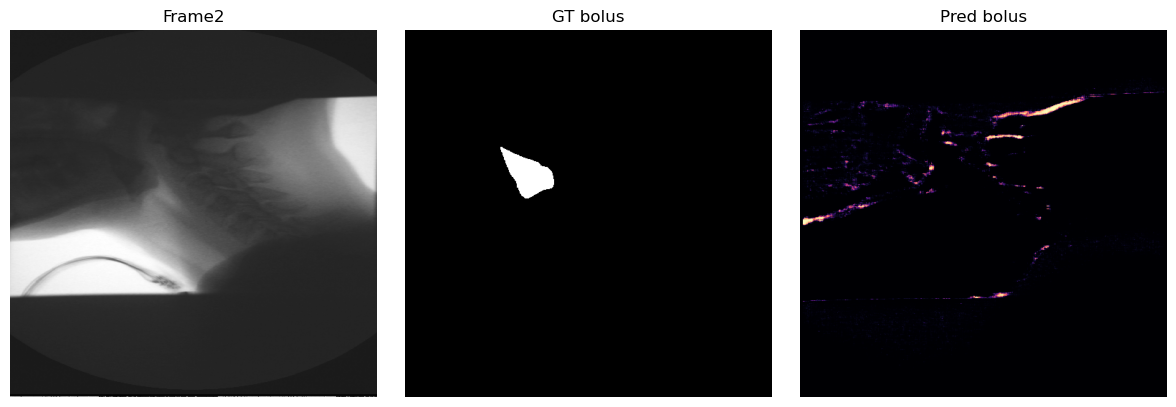

In [9]:
# quick visualization
attn_model.eval()
target_loader = data_loaders['test'] if len(splits['test']) else data_loaders['val']
with torch.no_grad():
    frame2, mask1 = next(iter(target_loader))
    prob = attn_model(frame2.to(device)).cpu()

idx = 0
fig, axes = plt.subplots(1, 3, figsize=(12,4))
axes[0].imshow(frame2[idx,0], cmap='gray'); axes[0].set_title('Frame2')
axes[1].imshow(mask1[idx,0], cmap='gray'); axes[1].set_title('GT bolus')
axes[2].imshow(prob[idx,0], cmap='magma', vmin=0, vmax=1); axes[2].set_title('Pred bolus')
for ax in axes: ax.axis('off')
plt.tight_layout(); plt.show()
